In the past, I've done some models using several libraries in Python without really understanding what I was doing. I want to implement multiple learning models, using less -or **none**- *pre-made* ML resources. I hope this will be reflected in a  deeper understanding on what each learning model does.

This time, I'll be implementing **Linear regression** in Python.

I'll be using `pandas` to import and process data sets, `numpy` to get useful linear algebra functions, and `pyplot` to make **really cute** graphics. Just take a look. Yeah... they're cute, aren't they?

## First, let's load our libraries.

In [1]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Import data

In [2]:
# import dataframe
df = pd.read_csv('../input/kc_house_data.csv')

# Convert date column to datetime
df['date'] = pd.to_datetime(df['date'], format='%Y%m%dT%H%M%S')

df['sqft_basement'].replace(to_replace=0, value=None, inplace=True)

## Create prediction target and feature matrix

In [3]:
df.columns.values

array(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated',
       'zipcode', 'lat', 'long', 'sqft_living15', 'sqft_lot15'], dtype=object)

By looking at column names, I can say that `'id'` and `'price'` will conform `'y'`, my prediction target.

I'm pretty skeptical that `'date'`, `'zipcode'`, `'lat'`,  or `'long'` are correlated to the price of the house. But I'll decide that later. For now, I'll assume everything **could** influence `'price'`, so `X`, my feature matrix, will be conformed by the whole dataframe, without `'id'` and `'price'`.

Let's create those matrices:

In [4]:
pred_target = ['id', 'price']
y = df[pred_target]    # 'y' only has 'pred_target[]' features
# delete 'pred_target[]' features from original df, and assign it to X.
    # it doesn't happen 'inplace'. df isn't modified
X = df.drop(pred_target, axis=1)

### Find Correlations

Before trying to find correlations between `X` and `y['price']`, I'll update `'date'`. 

In the original dataframe, date was a string. I converted it to datetime, and now I'll convert it to days (elapsed since the lowest value of the whole column). So, if I find any correlation, It will be able to work with.

In [5]:
# Convert datetime to integer in 'date'
X['date'] =  (X['date'] - X['date'].min())  / np.timedelta64(1,'D')

Now, let's go and calculate the correlation ratio between `X` and `'price'`

In [6]:
corr = X.corrwith(y['price'])
corr = corr.to_frame().transpose().rename({0:'price'})
corr

,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
price,-0.004357,0.30835,0.525138,0.702035,0.089661,0.256794,0.266369,0.397293,0.036362,0.667434,0.605567,0.175754,0.054012,0.126434,-0.053203,0.307003,0.021626,0.585379,0.082447


Now we must decide which features actually influence house price.

In Perason's association, coefficients between .10 and .29 represent a small association, coefficients between .30 and .49 represents a medium association, and coefficients above .50, a large association.

We'll generate two models:
1. Using features with only large associations.
2. Using features with medium and large associations.

So, let's choose our features.

We could do it manually, but we are not any grandma! Let's write some code to do it:

In [7]:
# create a tuple (string, float) list with (column names, values) of the corr dataframe
corr_temp = list(zip(corr.columns.values.tolist(), corr.iloc[0,:].tolist()))

# sort a tuple list, created by applying one condition on each
corr_above50 = sorted([t for t in corr_temp if t[1]>.5], key=lambda tup: tup[1])
corr_above30 = sorted([t for t in corr_temp if t[1]>.3], key=lambda tup: tup[1])


print ("Features with correlation bigger than .3:")
for feature in corr_above30:
    print ("\t", feature)
print ("Features with correlation bigger than .5:")
for feature in corr_above50:
    print ("\t", feature)

Features with correlation bigger than .3:
	 ('lat', 0.3070034799952186)
	 ('bedrooms', 0.3083495981456382)
	 ('view', 0.3972934882945045)
	 ('bathrooms', 0.5251375054139615)
	 ('sqft_living15', 0.5853789035795679)
	 ('sqft_above', 0.6055672983560783)
	 ('grade', 0.6674342560202366)
	 ('sqft_living', 0.7020350546118004)
Features with correlation bigger than .5:
	 ('bathrooms', 0.5251375054139615)
	 ('sqft_living15', 0.5853789035795679)
	 ('sqft_above', 0.6055672983560783)
	 ('grade', 0.6674342560202366)
	 ('sqft_living', 0.7020350546118004)


Yey! We got the features we wanted. Let's plot them, I want to see something pretty, or I'll go nuts.

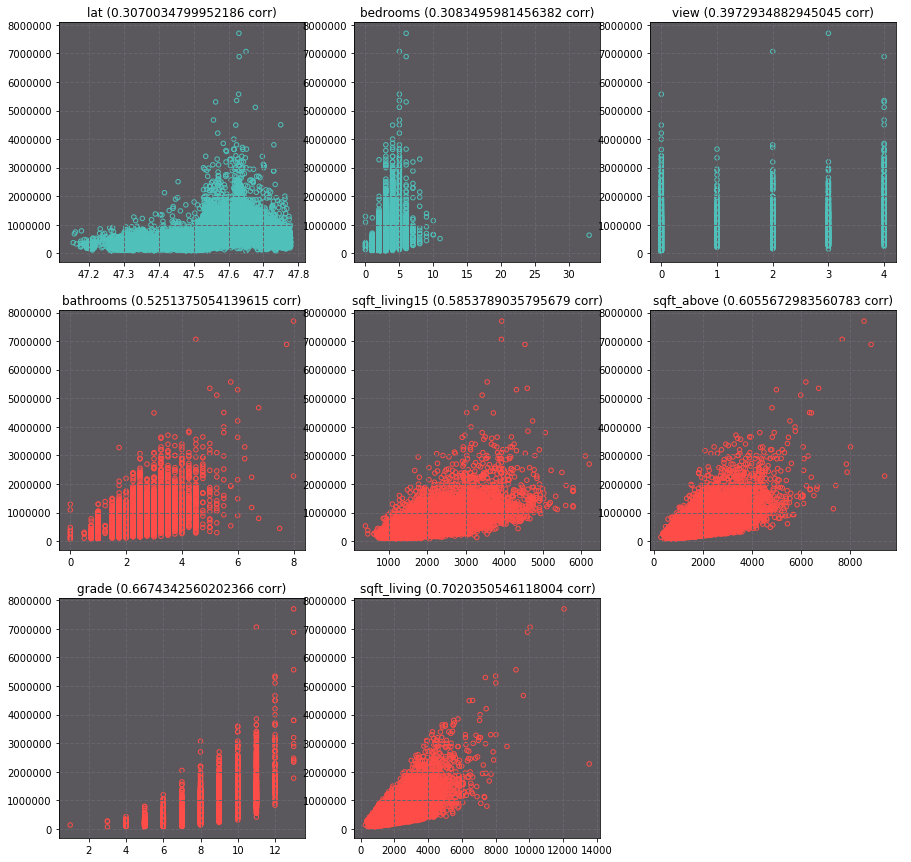

In [8]:
alpha = 1   # alpha of scatter plot markers
edgecolor1 = '#FF4D48'    # color of marker borders
edgecolor2 = '#4FC1BB'    # color of marker borders
color = 'none'    # fill color of marker borders
background = '#5A575D'    # background color for all plots
grid = '#68646B'    # grid color for all plots

plot_rows = int(np.ceil(np.sqrt(len(corr_above30))))
plot_cols = int(np.floor(np.sqrt(len(corr_above30))))

if(plot_rows*plot_cols < len(corr_above30)): plot_cols = plot_cols + 1
fig, axarr = plt.subplots(plot_rows, plot_cols, figsize = (15,15))
for i in range (plot_rows):
    for j in range (plot_cols):
        edgecolors = edgecolor1 if ((i*(plot_cols) + j) >= len(corr_above30) - len(corr_above50)) else edgecolor2
        if((i*(plot_cols) + j) >= len(corr_above30)): break
        axarr[i, j].scatter(X[corr_above30[i * (plot_cols) + j][0]], y['price'],
                            alpha = alpha, s = 20, c = color,
                            edgecolors=edgecolors);
        axarr[i, j].set_title (corr_above30[i * (plot_cols) + j][0] +
                               " (" + str(corr_above30[i * (plot_cols) + j][1]) + " corr)")
        axarr[i, j].patch.set_facecolor(background)
        axarr[i, j].grid(color=grid, linestyle='--', linewidth=1)

for i in range(plot_rows*plot_cols-len(corr_above30)):
    axarr[-1, -(i+1)].axis('off')
    
plt.show()

The graphs above, use all the features with medium or large association. The values in that *red-like* color, are the features with large association.

We will use all that features to create `X_m`, and all the *red-like* ones to create `X_l`:

In [9]:
X_m = X[[t[0] for t in corr_above30]]
X_l = X[[t[0] for t in corr_above50]]

Just because, we will normalize **all** features in both `X_m` and `X_l`!

To normalize, we have to implement this mathematical model:

$$
x_{i}:=\dfrac{x_{i}−\mu_{i}}{s_{i}}
$$

In [10]:
# X is the feature matrix to be normalized
def normalize(X):
    X_norm = X[:]    # copy feature matrix
    mu = []          # median matrix
    sigma = []       # std matrix
    for i in range(X.shape[1]):
        mu.append(X_norm.iloc[:,i].mean())        # append median of (arr[i]th) column
        sigma.append(X_norm.iloc[:,i].std())      # append std of (arr[i]th)column
        # normalize (arr[i]th) column
        X_norm.iloc[:,i] = (X_norm.iloc[:,i] - mu[i]) / sigma[i]
    return mu, sigma, X_norm

# mu list contains median of all normalized columns
# sigma list contains std of all normalized columns
# X_norm is X matrix normalized
[mu_m, sigma_m, X_m_norm] = normalize(X_m)
[mu_l, sigma_l, X_l_norm] = normalize(X_l)
[mu_w, sigma_w, X_w_norm] = normalize(X)

Now we modify `X_m_norm` and `X_l_norm`, adding the intercept term -a *ghost* feature with all values = 1-.

In [11]:
X_m_norm['intercept'] = 1
X_l_norm['intercept'] = 1
X_w_norm['temp'] = 1

X_m_norm.insert(0, 'intercept', X_m_norm['temp'])
X_l_norm.insert(0, 'intercept', X_l_norm['temp'])
X_w_norm.insert(0, 'intercept', X_w_norm['temp'])

X_m_norm.pop('temp')
X_l_norm.pop('temp')
X_w_norm.pop('temp')

KeyError: 'temp'

In [12]:
X_m_norm.head()

,lat,bedrooms,view,bathrooms,sqft_living15,sqft_above,grade,sqft_living,intercept
0,-0.352564,-0.398728,-0.305752,-1.447430,-0.943333,-0.734691,-0.558823,-0.979812,1
1,1.161541,-0.398728,-0.305752,0.175603,-0.432676,0.460830,-0.558823,0.533622,1
2,1.283507,-1.473925,-0.305752,-1.447430,1.070115,-1.229805,-1.409554,-1.426221,1
3,-0.283281,0.676469,-0.305752,1.149422,-0.914153,-0.891678,-0.558823,-0.130547,1
4,0.409541,-0.398728,-0.305752,-0.149004,-0.272184,-0.130892,0.291909,-0.435412,1


In [13]:
X_l_norm.head()

,bathrooms,sqft_living15,sqft_above,grade,sqft_living,intercept
0,-1.447430,-0.943333,-0.734691,-0.558823,-0.979812,1
1,0.175603,-0.432676,0.460830,-0.558823,0.533622,1
2,-1.447430,1.070115,-1.229805,-1.409554,-1.426221,1
3,1.149422,-0.914153,-0.891678,-0.558823,-0.130547,1
4,-0.149004,-0.272184,-0.130892,0.291909,-0.435412,1


It's great so far. Now, lets stablish `alpha` -the learning rate-, `iters` -the number of iterations-, and `theta` -theta vector-.

In [14]:
alpha = .0000000002
iters = 500
theta_l = [0] * len(X_l_norm.columns)
theta_m = [0] * len(X_m_norm.columns)
theta_w = [0] * len(X_w_norm.columns)

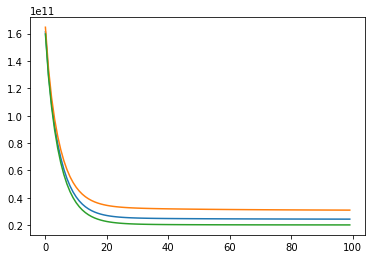

In [15]:
def computeCost(X, y, theta):
    return (X.dot(theta)).subtract(y['price']).pow(2).sum() / (2 * len(y))

def gradientDescent(X, y, theta, alpha, iters):
    m = len(y)
    J_history = []
    for i in range(iters):
        error = (X.dot(theta)).subtract(y['price']);
        for j in range(len(theta)):
            theta[j] = theta[j]-(alpha * error.multiply(X.iloc[:,j]).sum())/m;
            
        J_history.append(computeCost(X, y, theta));
    return theta, J_history

alpha = .1
iters = 100
theta_l = [0] * len(X_l_norm.columns)
theta_m = [0] * len(X_m_norm.columns)
theta_w = [0] * len(X_w_norm.columns)
[theta_l, J_history_l] = gradientDescent(X_l_norm, y, theta_l, alpha, iters)
[theta_m, J_history_m] = gradientDescent(X_m_norm, y, theta_m, alpha, iters)
[theta_w, J_history_w] = gradientDescent(X_w_norm, y, theta_w, alpha, iters)
plt.plot(J_history_m)
plt.plot(J_history_l)
plt.plot(J_history_w);

In [16]:
print("m error: ", J_history_m[-1])
print("l error: ", J_history_l[-1])
print("w error: ", J_history_w[-1])

m error:  24423773042.049477
l error:  31011774876.92323
w error:  20199787291.296875


In [17]:
ids = [3271300955,9830200380,4385700735,4385700765,1776460190,4040800360,9828700005,3024079063,
       6430500293,293910070,3449900030,7308900490,7852020250,3630200460,3425059141,259800410,
       6928600330,3905040070,2922701085,7974200777,6699300330,1118001360,1330850130,6880200030,
       4458300190,1771100440,8143100500,7424600020,9573120260,7853340330,34001304,1524079156,
       5430300171,1702901500,3751601501,5418650080,2770601800,1523049115,1509700050,8731960050,
       5146000070,5021900090,7550801206,3663500060,11200290,9474700020,616000140,722059020,
       8682220150,2922701175,9267200226,8658300315,1782000180,1221039058,461003835,8864000970,
       4222700130,1972202023,2725069164,4363700200,6431000749,7625702616,1771110720,8731951370,
       2473480560,7893800534,1561900180,3298700941,6713100031,7137900320,3205100080,4345000490,
       9558021010,724069070,3124049171,7839300185,5009600010,1922069099,8137500400,7582700075,
       9250900104,4178300040,3904920390,4305200070,7419500200,4157600120,7853321090,6021502300,
       7844200040,2968801130,1498303905,3383900048,5592900020,7519000585,1102000514,375000165,
       9165100375,8091400200,7985000010,3583300135]

results = pd.DataFrame()
for i in ids:
    ID = df.index[df['id'] == i].tolist()[0]
    temp = pd.DataFrame([[df.iloc[ID,0],
                          df.iloc[ID,2],
                          df.iloc[ID,2] - X_m_norm.iloc[ID,:].dot(theta_m),
                          df.iloc[ID,2] - X_l_norm.iloc[ID,:].dot(theta_l),
                          X_w_norm.iloc[ID,:].dot(theta_w),
                         ]],
                        columns=['id', 'real', 'error predicted m', 'error predicted l', 'error predicted w']
                       )
    results = results.append(temp, ignore_index=True)

results

,id,real,error predicted m,error predicted l,error predicted w
0,3271300955,554729.0,-93928.469240,-97003.145757,7.593733e+05
1,9830200380,653000.0,-416609.755896,-251880.475293,9.865941e+05
2,4385700735,790000.0,291073.158969,328926.721598,5.699989e+05
3,4385700765,850000.0,468414.438293,495584.090874,5.686672e+05
4,1776460190,429900.0,-300082.521232,-181289.009343,6.094146e+05
5,4040800360,420000.0,57935.827403,99934.051134,3.951303e+05
6,9828700005,440000.0,119980.731576,150288.157193,3.244298e+05
7,3024079063,850000.0,-111835.172805,-225895.497412,7.720000e+05
8,6430500293,395000.0,10222.686101,118583.771868,5.356357e+05
9,293910070,653750.0,-133683.309103,-88629.121418,7.571745e+05


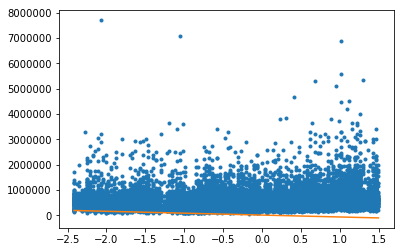

In [18]:
for i in range(12,13):
    best_fit_x = np.linspace(X_w_norm.iloc[:,i].min(), X_w_norm.iloc[:,i].max(), 20)
    best_fit_y = [theta_w[0] + theta_w[i]*xx for xx in best_fit_x]
    plt.plot(X_w_norm.iloc[:,i], y['price'], '.')
    plt.plot(best_fit_x, best_fit_y, '-')
# best_fit_x = np.linspace(0, X_w_norm['sqft_living'].max(), 20)
# print(best_fit_x)
# best_fit_y = [theta_w[1] + theta_w[0] + theta_w[1] + theta_w[2]*xx for xx in best_fit_x ]
# plt.plot(X_w_norm['sqft_living'], y['price'], '.')
# plt.plot(best_fit_x, best_fit_y, '-')